In [1]:
from datetime import datetime
import pandas as pd

In [2]:
import devanalyst.simulation.statics as S_

from devanalyst.simulation.simulationModels import ModelsConfig, DefaultCostModel, MeritocraticCostModel, \
DistributedLagQualityModel, GreedyAllocationModel, NoLaggardsAllocationModel
from devanalyst.simulation.businessObjects import TicketsRepo, Backlog, UserStoryStatus
from devanalyst.simulation.Engine import ReleaseSimulationEngine

from devanalyst.metrics.ProductivityMetrics import CommitsAnalysis, DragAnalyzer
import devanalyst.simulation.generateTimecards as timecard


importing Jupyter notebook from c:\users\aleja\documents\code\chateauclaudia-labs\devanalyst\devanalyst\simulation\statics.ipynb
importing Jupyter notebook from c:\users\aleja\documents\code\chateauclaudia-labs\devanalyst\devanalyst\simulation\simulationModels.ipynb
importing Jupyter notebook from c:\users\aleja\documents\code\chateauclaudia-labs\devanalyst\devanalyst\simulation\businessObjects.ipynb
importing Jupyter notebook from c:\users\aleja\documents\code\chateauclaudia-labs\devanalyst\devanalyst\simulation\Engine.ipynb
importing Jupyter notebook from c:\users\aleja\documents\code\chateauclaudia-labs\devanalyst\devanalyst\simulation\generateTimecards.ipynb
importing Jupyter notebook from c:\users\aleja\documents\code\chateauclaudia-labs\devanalyst\devanalyst\metrics\ProductivityMetrics.ipynb


In [3]:
import devanalyst.test_utils.test_utils as tu_
from devanalyst.test_utils.test_utils import ExpectedOutputCleaner

importing Jupyter notebook from c:\users\aleja\documents\code\chateauclaudia-labs\devanalyst\devanalyst\test_utils\test_utils.ipynb


<h1>Test Simple Productivity</h1>
Tests commits productivity under multiple scenarios, but in all cases assumes no interference. Therefore what differs
across scenarios is how work loads are partitioned among developers. There is no 'systemic waste' to eliminate in any of
these scenarios since there is no interference assumed.

In [25]:
# Implement test logic, and run it

#Helper function. Returns the time entries (as a dataframe) and logs for the release cycle. Also mutates 'modelsConfig'
# 
# -modelsConfig: configuration of what models to use to simulate a release cycle. It is expected to be passed in 
# 'minimal form', i.e., only the models should be set. Everything else in 'modelsConfig' is likely to be mutated by 
# this function in the process of generating the release cycle. In particular, these are mutated: 
#      a) the repositories that 'modelsConfig' refers to, and 
#      b) the random seed used by 'modelsConfig'.
#
def run_release(modelsConfig):
    RELEASE_DURATION = 60
    SPRINT_DURATION = 10
    NUMBER_OF_SPRINTS = 30

    modelsConfig.random.reset(271)

    teams_df, stories_dfDUMMY, globalRepo = tu_.initTestData(tu_.DEV_DF, tu_.PM_DF, \
                                                        RELEASE_DURATION, SPRINT_DURATION, modelsConfig)
    modelsConfig.globalRepo = globalRepo
    NUMBER_OF_SPRINTS = 30
    entries_df, log = timecard.runReleaseCycle(datetime(2018, 1, 15), SPRINT_DURATION, NUMBER_OF_SPRINTS, modelsConfig)
    return entries_df, log

#Test logic
def test_simple_productivity():
    output = {}

    # Case 1: no delays
    modelsConfig1 = ModelsConfig([DefaultCostModel(0.0)], [DistributedLagQualityModel()], GreedyAllocationModel())
    entries1_df, log1                          = run_release(modelsConfig1)
    commits1_impl, commits1_bugs, commits1_all = CommitsAnalysis.tabulateCommits(modelsConfig1)
    
    # Case 2: Meritocratic delays without work stealing
    modelsConfig2 = ModelsConfig([MeritocraticCostModel()], [DistributedLagQualityModel()], GreedyAllocationModel())
    entries2_df, log2                          = run_release(modelsConfig2)
    commits2_impl, commits2_bugs, commits2_all = CommitsAnalysis.tabulateCommits(modelsConfig2)

    # Case 3: Meritocratic delays with work stealing
    modelsConfig3 = ModelsConfig([MeritocraticCostModel()], [DistributedLagQualityModel()], NoLaggardsAllocationModel())
    entries3_df, log3                          = run_release(modelsConfig3)
    commits3_impl, commits3_bugs, commits3_all = CommitsAnalysis.tabulateCommits(modelsConfig3)
    
    
    output['no_delay']                 = commits1_impl
    output['meritocratic']             = commits2_impl
    output['work_stealing']            = commits3_impl

    return output

# Run the test
test_simple_ACTUAL = test_simple_productivity()

In [26]:
# Uncomment to update expected output to match the actual one

# Helper method
def create_test_simple_EXPECTED():
    tu_.createExpectedOutput(test_simple_ACTUAL['no_delay'],     'productivity.test_simple.no_delay',
                                                                           module = 'metrics')
    tu_.createExpectedOutput(test_simple_ACTUAL['meritocratic'], 'productivity.test_simple.meritocratic',
                                                                           module = 'metrics')    
    tu_.createExpectedOutput(test_simple_ACTUAL['work_stealing'],'productivity.test_simple.work_stealing',
                                                                           module = 'metrics')

# Uncomment to update expected output to match the actual one, and then put the comment back
#create_test_simple_EXPECTED()

In [27]:
# Load expected output, update the EXPECTED and ACTUAL dictionaries, and check test is OK
list_cols = [] # Lists are loaded as strings, so require special processing on load

test_simple_EXPECTED = {}


# When loading the CSV files for expected output, they will introduce a spurious integer index. So replace that
# by using the 'Developer' column as the index, which is how the actuals are indexed, so that expected matches actuals.
test_simple_EXPECTED['no_delay']      = tu_.loadExpectedOutput('productivity.test_simple.no_delay', 
                                                                            list_cols,
                                                                           module = 'metrics').set_index('Developer')
                                                                            
test_simple_EXPECTED['meritocratic']  = tu_.loadExpectedOutput('productivity.test_simple.meritocratic', 
                                                                            list_cols,
                                                                           module = 'metrics').set_index('Developer')

test_simple_EXPECTED['work_stealing'] = tu_.loadExpectedOutput('productivity.test_simple.work_stealing', 
                                                                            list_cols,
                                                                           module = 'metrics').set_index('Developer')

tu_.EXPECTED['productivity.test_simple.no_delay']      = test_simple_EXPECTED['no_delay']
tu_.EXPECTED['productivity.test_simple.meritocratic']  = test_simple_EXPECTED['meritocratic']
tu_.EXPECTED['productivity.test_simple.work_stealing'] = test_simple_EXPECTED['work_stealing']

tu_.ACTUAL['productivity.test_simple.no_delay']        = test_simple_ACTUAL['no_delay']
tu_.ACTUAL['productivity.test_simple.meritocratic']    = test_simple_ACTUAL['meritocratic']
tu_.ACTUAL['productivity.test_simple.work_stealing']   = test_simple_ACTUAL['work_stealing']

tu_.testOK('productivity.test_simple.no_delay'), \
tu_.testOK('productivity.test_simple.meritocratic'), \
tu_.testOK('productivity.test_simple.work_stealing'), \


(True, True, False)

In [ ]:
# Uncomment to interactively visualize the logs, and then comment again once interactive analysis is done. Commenting these
# lines after interactive analysis is completed is required as test harness can't load these visualiations
# libraries so leaving this uncommented will crash the entire test harness.
# NOTE: MAY NEED TO RUN TWICE, as there seems to be a bug in Jupyter Notebook so on the first run there is no output
#CommitsAnalysis.chartCommits(test_simple_ACTUAL['no_delay'])

In [ ]:
# Uncomment to interactively visualize the logs, and then comment again once interactive analysis is done. Commenting these
# lines after interactive analysis is completed is required as test harness can't load these visualiations
# libraries so leaving this uncommented will crash the entire test harness.
# NOTE: MAY NEED TO RUN TWICE, as there seems to be a bug in Jupyter Notebook so on the first run there is no output
#CommitsAnalysis.chartCommits(test_simple_ACTUAL['meritocratic'])

In [ ]:
# Uncomment to interactively visualize the logs, and then comment again once interactive analysis is done. Commenting these
# lines after interactive analysis is completed is required as test harness can't load these visualiations
# libraries so leaving this uncommented will crash the entire test harness.
# NOTE: MAY NEED TO RUN TWICE, as there seems to be a bug in Jupyter Notebook so on the first run there is no output
#CommitsAnalysis.chartCommits(test_simple_ACTUAL['work_stealing'])

In [ ]:
test_simple_ACTUAL['no_delay'][:5]

In [ ]:
test_simple_EXPECTED['no_delay'][:5]

In [ ]:
test_simple_ACTUAL['meritocratic'][:5]

In [ ]:
test_simple_EXPECTED['meritocratic'][:5]

In [ ]:
test_simple_ACTUAL['work_stealing'][:5]

In [ ]:
test_simple_EXPECTED['work_stealing'][:5]

<h1>Test drag removal</h1>

In [30]:
# Implement test logic, and run it

#Test logic
def test_drag():
    output = {}
    RELEASE_DURATION = 60
    SPRINT_DURATION = 10
    NUMBER_OF_SPRINTS = 30

    # Look at full team, with anyone able to work in anybody else's area.
    singleTeam_df = tu_.DEV_DF.copy()
    singleTeam_df['Scrum Team'] = 'Entire R&D'

    # Configure models
    modelsConfig = ModelsConfig([MeritocraticCostModel()], [DistributedLagQualityModel()], NoLaggardsAllocationModel())
    modelsConfig.random.reset(271)
    teams_df, stories_dfDUMMY, globalRepo = tu_.initTestData(singleTeam_df, tu_.PM_DF, \
                                                             RELEASE_DURATION, SPRINT_DURATION, modelsConfig)
    modelsConfig.globalRepo = globalRepo
    
    # Run simulations
    engine = ReleaseSimulationEngine(modelsConfig)
    analyzer = DragAnalyzer(engine, NUMBER_OF_SPRINTS, SPRINT_DURATION, datetime(2018, 1, 15), 0.9)
    analyzer.runSimulations()
    impact = analyzer.tabulateDragImpact()
    

    output['Burnout_with_drag']         = analyzer.stats['With_drag']    .burnout
    output['Burnout_without_drag']      = analyzer.stats['Without_drag'] .burnout
    output['Entries_with_drag']         = analyzer.stats['With_drag']    .entries_df
    output['Entries_without_drag']      = analyzer.stats['Without_drag'] .entries_df
    output['Commits_impl_with_drag']    = analyzer.stats['With_drag']    .commits_impl
    output['Commits_impl_without_drag'] = analyzer.stats['Without_drag'] .commits_impl
    output['Commits_bugs_with_drag']    = analyzer.stats['With_drag']    .commits_bugs
    output['Commits_bugs_without_drag'] = analyzer.stats['Without_drag'] .commits_bugs
    output['Commits_all_with_drag']     = analyzer.stats['With_drag']    .commits_all
    output['Commits_all_without_drag']  = analyzer.stats['Without_drag'] .commits_all
    output['Impact']                    = impact    

    return output, analyzer

# Run the test
test_drag_ACTUAL, analyzer = test_drag()

In [31]:
# Uncomment to update expected output to match the actual one

# Helper method
def create_drag_EXPECTED():
    tu_.createExpectedOutput(test_drag_ACTUAL['Burnout_with_drag'],    
                             'productivity.test_drag.Burnout_with_drag', module = 'metrics')
    tu_.createExpectedOutput(test_drag_ACTUAL['Burnout_without_drag'],    
                             'productivity.test_drag.Burnout_without_drag', module = 'metrics')
    tu_.createExpectedOutput(test_drag_ACTUAL['Entries_with_drag'],    
                             'productivity.test_drag.Entries_with_drag', module = 'metrics')
    tu_.createExpectedOutput(test_drag_ACTUAL['Entries_without_drag'],     
                             'productivity.test_drag.Entries_without_drag', module = 'metrics')
    tu_.createExpectedOutput(test_drag_ACTUAL['Commits_impl_with_drag'],    
                             'productivity.test_drag.Commits_impl_with_drag', module = 'metrics')
    tu_.createExpectedOutput(test_drag_ACTUAL['Commits_impl_without_drag'], 
                             'productivity.test_drag.Commits_impl_without_drag', module = 'metrics')
    tu_.createExpectedOutput(test_drag_ACTUAL['Commits_bugs_with_drag'],    
                             'productivity.test_drag.Commits_bugs_with_drag', module = 'metrics')
    tu_.createExpectedOutput(test_drag_ACTUAL['Commits_bugs_without_drag'],    
                             'productivity.test_drag.Commits_bugs_without_drag', module = 'metrics')
    tu_.createExpectedOutput(test_drag_ACTUAL['Commits_all_with_drag'],    
                             'productivity.test_drag.Commits_all_with_drag', module = 'metrics')
    tu_.createExpectedOutput(test_drag_ACTUAL['Commits_all_without_drag'],    
                             'productivity.test_drag.Commits_all_without_drag', module = 'metrics')
    tu_.createExpectedOutput(test_drag_ACTUAL['Impact'],    
                             'productivity.test_drag.Impact', module = 'metrics')

# Uncomment to update expected output to match the actual one, and then put the comment back
#create_drag_EXPECTED()

In [32]:
# Load expected output, update the EXPECTED and ACTUAL dictionaries, and check test is OK
list_cols = [] # Lists are loaded as strings, so require special processing on load

test_drag_EXPECTED = {}

test_drag_EXPECTED['Burnout_with_drag']         = tu_.loadExpectedOutput('productivity.test_drag.Burnout_with_drag', 
                                                                         list_cols,
                                                                         module = 'metrics')
test_drag_EXPECTED['Burnout_without_drag']      = tu_.loadExpectedOutput('productivity.test_drag.Burnout_without_drag', 
                                                                         list_cols,
                                                                         module = 'metrics')
test_drag_EXPECTED['Entries_with_drag']         = tu_.loadExpectedOutput('productivity.test_drag.Entries_with_drag', 
                                                                         list_cols,
                                                                         module = 'metrics')
test_drag_EXPECTED['Entries_without_drag']      = tu_.loadExpectedOutput('productivity.test_drag.Entries_without_drag', 
                                                                         list_cols,
                                                                         module = 'metrics')
test_drag_EXPECTED['Commits_impl_with_drag']    = tu_.loadExpectedOutput('productivity.test_drag.Commits_impl_with_drag', 
                                                                         list_cols,
                                                                         module = 'metrics').set_index('Developer')
test_drag_EXPECTED['Commits_impl_without_drag'] = tu_.loadExpectedOutput('productivity.test_drag.Commits_impl_without_drag', 
                                                                         list_cols,
                                                                         module = 'metrics').set_index('Developer')
test_drag_EXPECTED['Commits_bugs_with_drag']    = tu_.loadExpectedOutput('productivity.test_drag.Commits_bugs_with_drag', 
                                                                         list_cols,
                                                                         module = 'metrics').set_index('Developer')
test_drag_EXPECTED['Commits_bugs_without_drag'] = tu_.loadExpectedOutput('productivity.test_drag.Commits_bugs_without_drag', 
                                                                         list_cols,
                                                                         module = 'metrics').set_index('Developer')
test_drag_EXPECTED['Commits_all_with_drag']     = tu_.loadExpectedOutput('productivity.test_drag.Commits_all_with_drag', 
                                                                         list_cols,
                                                                         module = 'metrics').set_index('Developer')
test_drag_EXPECTED['Commits_all_without_drag']  = tu_.loadExpectedOutput('productivity.test_drag.Commits_all_without_drag', 
                                                                         list_cols,
                                                                         module = 'metrics').set_index('Developer')
test_drag_EXPECTED['Impact']                    = tu_.loadExpectedOutput('productivity.test_drag.Impact', 
                                                                         list_cols,
                                                                         module = 'metrics')

# Rounding inaccuracies in saving and loading CSV will create an artificial mismatch between ACTUAL and EXPECTED
# So round EXPECTED and ACTUAL to 6 decimal places for sensitive fields (any float)
ExpectedOutputCleaner.cleanRoundingNoise(['Time Spent'],
                                        ['Entries_with_drag', 'Entries_without_drag'],
                                        test_drag_EXPECTED,
                                        test_drag_ACTUAL)
ExpectedOutputCleaner.cleanRoundingNoise(['Effort', 'Implementation Effort', 'Debugging Effort', 'Cum % Completion'],
                                        ['Burnout_with_drag', 'Burnout_without_drag'],
                                        test_drag_EXPECTED,
                                        test_drag_ACTUAL)

# Dates are loaded as strings, not pd.Timestamps, so to avoid spurious mismatches between ACTUAL (which 
# represents dates as pd.Timestamps) and EXPECTED, convert the EXPECTED dates into pd.Timestamps
ExpectedOutputCleaner.standardizeDates(['Date'],
                                      ['Entries_with_drag', 'Entries_without_drag'],
                                      test_drag_EXPECTED)

# Align columns
ExpectedOutputCleaner.alignColumns(['Commits_all_with_drag', 'Commits_all_without_drag'],
                                   test_drag_EXPECTED,
                                  test_drag_ACTUAL)

tu_.EXPECTED['productivity.test_drag.Burnout_with_drag']             = test_drag_EXPECTED['Burnout_with_drag']
tu_.EXPECTED['productivity.test_drag.Burnout_without_drag']          = test_drag_EXPECTED['Burnout_without_drag']
tu_.EXPECTED['productivity.test_drag.Entries_with_drag']             = test_drag_EXPECTED['Entries_with_drag']
tu_.EXPECTED['productivity.test_drag.Entries_without_drag']          = test_drag_EXPECTED['Entries_without_drag']
tu_.EXPECTED['productivity.test_drag.Commits_impl_with_drag']        = test_drag_EXPECTED['Commits_impl_with_drag']
tu_.EXPECTED['productivity.test_drag.Commits_impl_without_drag']     = test_drag_EXPECTED['Commits_impl_without_drag']
tu_.EXPECTED['productivity.test_drag.Commits_bugs_with_drag']        = test_drag_EXPECTED['Commits_bugs_with_drag']
tu_.EXPECTED['productivity.test_drag.Commits_bugs_without_drag']     = test_drag_EXPECTED['Commits_bugs_without_drag']
tu_.EXPECTED['productivity.test_drag.Commits_all_with_drag']         = test_drag_EXPECTED['Commits_all_with_drag']
tu_.EXPECTED['productivity.test_drag.Commits_all_without_drag']      = test_drag_EXPECTED['Commits_all_without_drag']
tu_.EXPECTED['productivity.test_drag.Impact']                        = test_drag_EXPECTED['Impact']

tu_.ACTUAL['productivity.test_drag.Burnout_with_drag']             = test_drag_ACTUAL['Burnout_with_drag']
tu_.ACTUAL['productivity.test_drag.Burnout_without_drag']          = test_drag_ACTUAL['Burnout_without_drag']
tu_.ACTUAL['productivity.test_drag.Entries_with_drag']             = test_drag_ACTUAL['Entries_with_drag']
tu_.ACTUAL['productivity.test_drag.Entries_without_drag']          = test_drag_ACTUAL['Entries_without_drag']
tu_.ACTUAL['productivity.test_drag.Commits_impl_with_drag']        = test_drag_ACTUAL['Commits_impl_with_drag']
tu_.ACTUAL['productivity.test_drag.Commits_impl_without_drag']     = test_drag_ACTUAL['Commits_impl_without_drag']
tu_.ACTUAL['productivity.test_drag.Commits_bugs_with_drag']        = test_drag_ACTUAL['Commits_bugs_with_drag']
tu_.ACTUAL['productivity.test_drag.Commits_bugs_without_drag']     = test_drag_ACTUAL['Commits_bugs_without_drag']
tu_.ACTUAL['productivity.test_drag.Commits_all_with_drag']         = test_drag_ACTUAL['Commits_all_with_drag']
tu_.ACTUAL['productivity.test_drag.Commits_all_without_drag']      = test_drag_ACTUAL['Commits_all_without_drag']
tu_.ACTUAL['productivity.test_drag.Impact']                        = test_drag_ACTUAL['Impact']

tu_.testOK('productivity.test_drag.Burnout_with_drag'), \
tu_.testOK('productivity.test_drag.Burnout_without_drag'), \
tu_.testOK('productivity.test_drag.Entries_with_drag'), \
tu_.testOK('productivity.test_drag.Entries_without_drag'), \
tu_.testOK('productivity.test_drag.Commits_impl_with_drag'), \
tu_.testOK('productivity.test_drag.Commits_impl_without_drag'), \
tu_.testOK('productivity.test_drag.Commits_bugs_with_drag'), \
tu_.testOK('productivity.test_drag.Commits_bugs_without_drag'), \
tu_.testOK('productivity.test_drag.Commits_all_with_drag'), \
tu_.testOK('productivity.test_drag.Commits_all_without_drag'), \
tu_.testOK('productivity.test_drag.Impact'), \

(True, True, True, True, True, True, True, True, True, True, True)

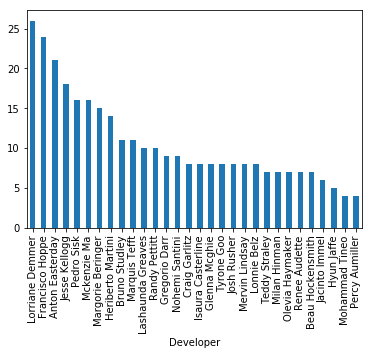

In [34]:
# Uncomment to see chart. Then comment it again, as test harness will fail if it is not commented since it can't
# load graphic libraries. Also, you may need to run this twice (some Jupyter bug apparently blocks rendering on
# a first call)
#CommitsAnalysis.chartCommits(analyzer.stats['With_drag'].commits_impl)

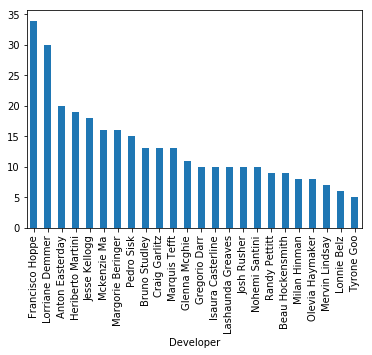

In [35]:
# Uncomment to see chart. Then comment it again, as test harness will fail if it is not commented since it can't
# load graphic libraries. Also, you may need to run this twice (some Jupyter bug apparently blocks rendering on
# a first call)
#CommitsAnalysis.chartCommits(analyzer.stats['Without_drag'].commits_impl)

In [ ]:
test_drag_ACTUAL['Burnout_with_drag'][:5]

In [ ]:
test_drag_EXPECTED['Burnout_with_drag'][:5]

In [ ]:
test_drag_ACTUAL['Burnout_without_drag'][:5]

In [ ]:
test_drag_EXPECTED['Burnout_without_drag'][:5]

In [13]:
test_drag_ACTUAL['Entries_with_drag'][:5]

,Sprint,Date,Team,Developer,User Story,Task Type,Task Description,Time Spent
0,1,2018-01-29,Team Entire R&D,Anton Easterday,UserStory #186,UNFINISHED_STORIES,Story implementation,10.0
1,1,2018-01-29,Team Entire R&D,Anton Easterday,UserStory #87,UNFINISHED_STORIES,Story implementation,0.0
2,1,2018-01-29,Team Entire R&D,Anton Easterday,UserStory #220,UNFINISHED_STORIES,Story implementation,0.0
3,1,2018-01-29,Team Entire R&D,Beau Hockensmith,UserStory #164,UNFINISHED_STORIES,Story implementation,10.0
4,1,2018-01-29,Team Entire R&D,Bruno Studley,UserStory #146,UNFINISHED_STORIES,Story implementation,10.0


In [14]:
test_drag_EXPECTED['Entries_with_drag'][:5]

,Sprint,Date,Team,Developer,User Story,Task Type,Task Description,Time Spent
0,1,2018-01-29,Team Entire R&D,Anton Easterday,UserStory #186,UNFINISHED_STORIES,Story implementation,10.0
1,1,2018-01-29,Team Entire R&D,Anton Easterday,UserStory #87,UNFINISHED_STORIES,Story implementation,0.0
2,1,2018-01-29,Team Entire R&D,Anton Easterday,UserStory #220,UNFINISHED_STORIES,Story implementation,0.0
3,1,2018-01-29,Team Entire R&D,Beau Hockensmith,UserStory #164,UNFINISHED_STORIES,Story implementation,10.0
4,1,2018-01-29,Team Entire R&D,Bruno Studley,UserStory #146,UNFINISHED_STORIES,Story implementation,10.0


In [ ]:
test_drag_ACTUAL['Entries_without_drag'][:5]

In [ ]:
test_drag_EXPECTED['Entries_without_drag'][:5]

In [15]:
test_drag_ACTUAL['Commits_impl_with_drag'][:5]

,User Story Id
Developer,
Anton Easterday,21
Beau Hockensmith,7
Bruno Studley,11
Craig Garlitz,8
Francisco Hoppe,24


In [16]:
test_drag_EXPECTED['Commits_impl_with_drag'][:5]

,Developer,User Story Id
0,Anton Easterday,21
1,Beau Hockensmith,7
2,Bruno Studley,11
3,Craig Garlitz,8
4,Francisco Hoppe,24


In [ ]:
test_drag_ACTUAL['Commits_impl_without_drag'][:5]

In [ ]:
test_drag_EXPECTED['Commits_impl_without_drag'][:5]

In [ ]:
test_drag_ACTUAL['Commits_bugs_with_drag'][:5]

In [ ]:
test_drag_EXPECTED['Commits_bugs_with_drag'][:5]

In [20]:
test_drag_ACTUAL['Commits_bugs_without_drag'][:5]

,Ticket Id
Developer,
Anton Easterday,8
Beau Hockensmith,2
Bruno Studley,9
Craig Garlitz,5
Francisco Hoppe,16


In [ ]:
test_drag_EXPECTED['Commits_bugs_without_drag'][:5]

In [ ]:
test_drag_ACTUAL['Commits_all_with_drag'][:5]

In [ ]:
test_drag_EXPECTED['Commits_all_with_drag'][:5]

In [23]:
a = test_drag_ACTUAL['Commits_all_without_drag']
e = test_drag_EXPECTED['Commits_all_without_drag']
a.columns, e.columns

(RangeIndex(start=0, stop=1, step=1), Index(['0'], dtype='object'))

In [18]:
test_drag_ACTUAL['Commits_all_without_drag'][:5]

,0
Developer,
Anton Easterday,28
Beau Hockensmith,11
Bruno Studley,22
Craig Garlitz,18
Francisco Hoppe,50


In [19]:
test_drag_EXPECTED['Commits_all_without_drag'][:5]

,0
Developer,
Anton Easterday,28
Beau Hockensmith,11
Bruno Studley,22
Craig Garlitz,18
Francisco Hoppe,50


In [22]:
test_drag_ACTUAL['Impact']

,Metric,Full R&D Team,Without drag,% difference
0,Headcount,30.0,24.0,-20.00
1,Implementation Effort (days),4692.0,4343.0,-7.44
2,Debugging Effort (days),460.0,414.0,-9.92
3,Total Effort (days),5151.0,4757.0,-7.66
4,Cost ($),477814.0,454002.0,-4.98
5,Stories completed (#),320.0,320.0,0.00
6,When implementation is completed (sprint #),22.0,26.0,18.18
7,When implementation is 90.0% completed (sprint #),18.0,20.0,11.11


In [ ]:
test_drag_EXPECTED['Impact']